In [5]:
import torch
from segment_anything import SamPredictor, build_sam
import cv2
import numpy as np
import matplotlib.pyplot as plt

import requests
from PIL import Image, ImageEnhance
from io import BytesIO
import os
import glob
import pandas as pd

%cd GroundingDINO/
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, predict
%cd ..

from typing import Tuple
import math
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

/home/jupyter/GroundingDINO
/home/jupyter


device(type='cuda')

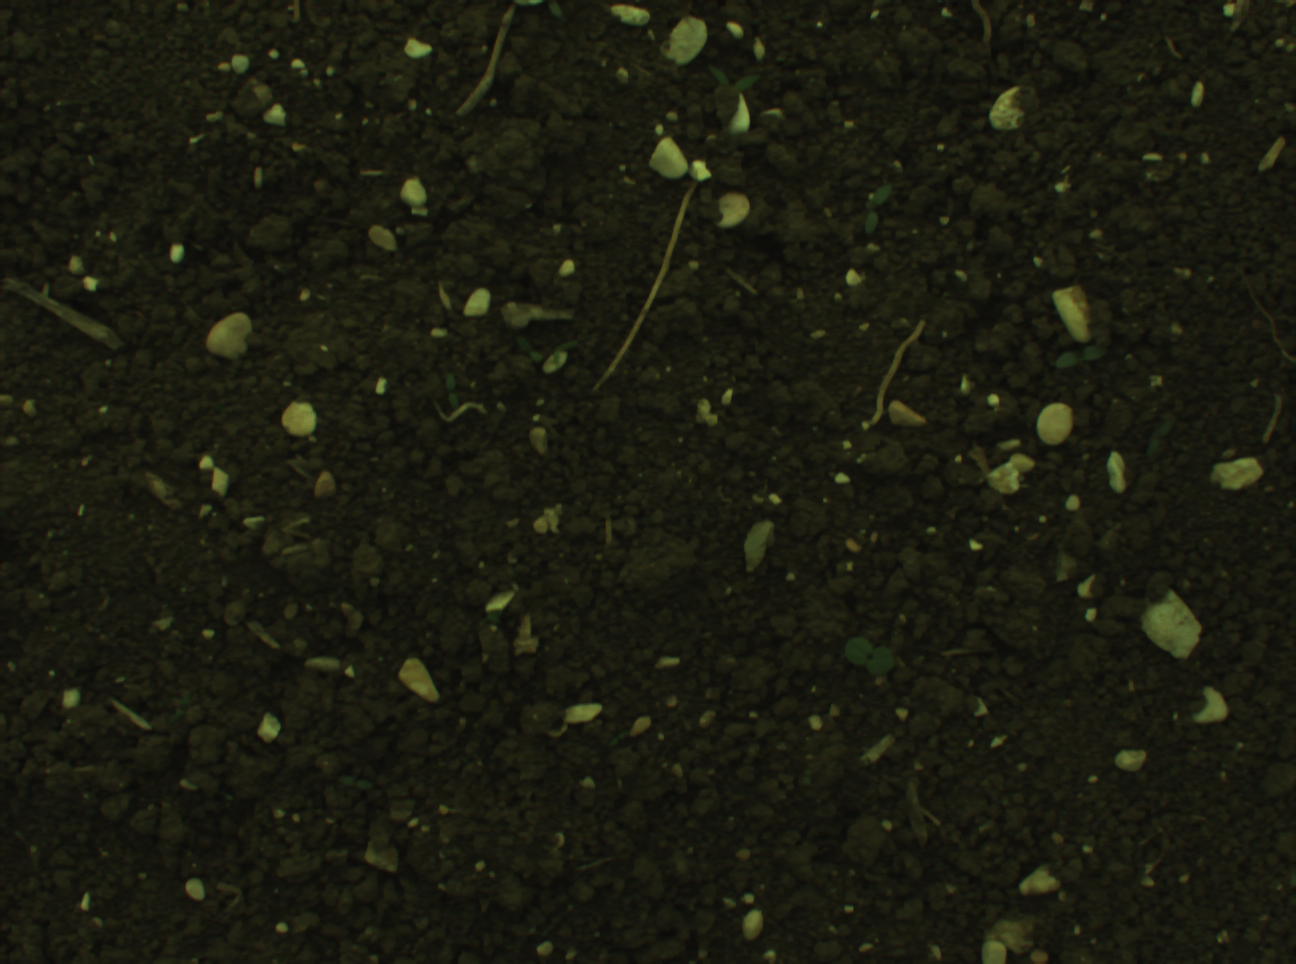

In [6]:
rgb_path = "Dataset/jesi_05_12/rgb/jesi_05_12__0_4min_rid_frame101.png"
nir_path = "Dataset/jesi_05_12/nir/jesi_05_12__0_4min_rid_frame101.png"
rgb_img = Image.open(rgb_path)
nir = Image.open(nir_path)
r, g, b = rgb_img.split()
rgb_img

In [7]:
def calculate_ndvi(b1, b2, b3 = 0):
  b1 = np.array(b1, dtype=float)
  b2 = np.array(b2, dtype=float)
  if not (b1.shape == b2.shape):
    raise ValueError("Both arrays should have the same dimensions")
  with np.errstate(divide="ignore"):
      n_diff = (b2 - b1) / (b1 + b2 - b3)
  if np.isinf(n_diff).any():
      n_diff[np.isinf(n_diff)] = np.nan
  if np.isnan(n_diff).any():
      n_diff = np.ma.masked_invalid(n_diff)

  ndvi_mean = np.mean(n_diff)
  return n_diff, (n_diff*255).astype(np.uint8), ndvi_mean

-0.06723883419530914


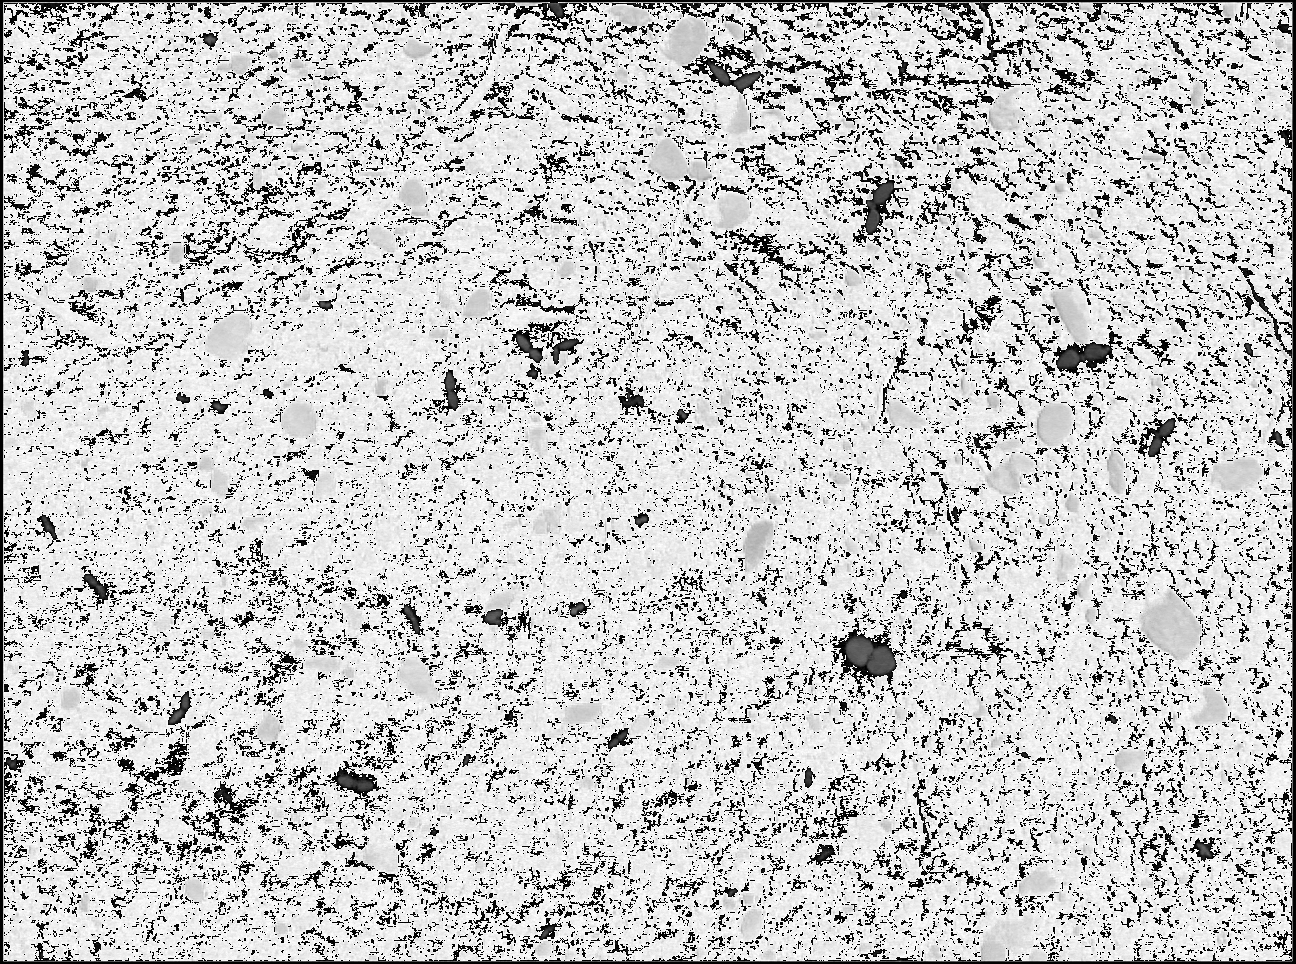

In [8]:
ndvi_img, ndvi_img1, ndvi = calculate_ndvi(r, nir)
print(ndvi)
Image.fromarray(ndvi_img1)

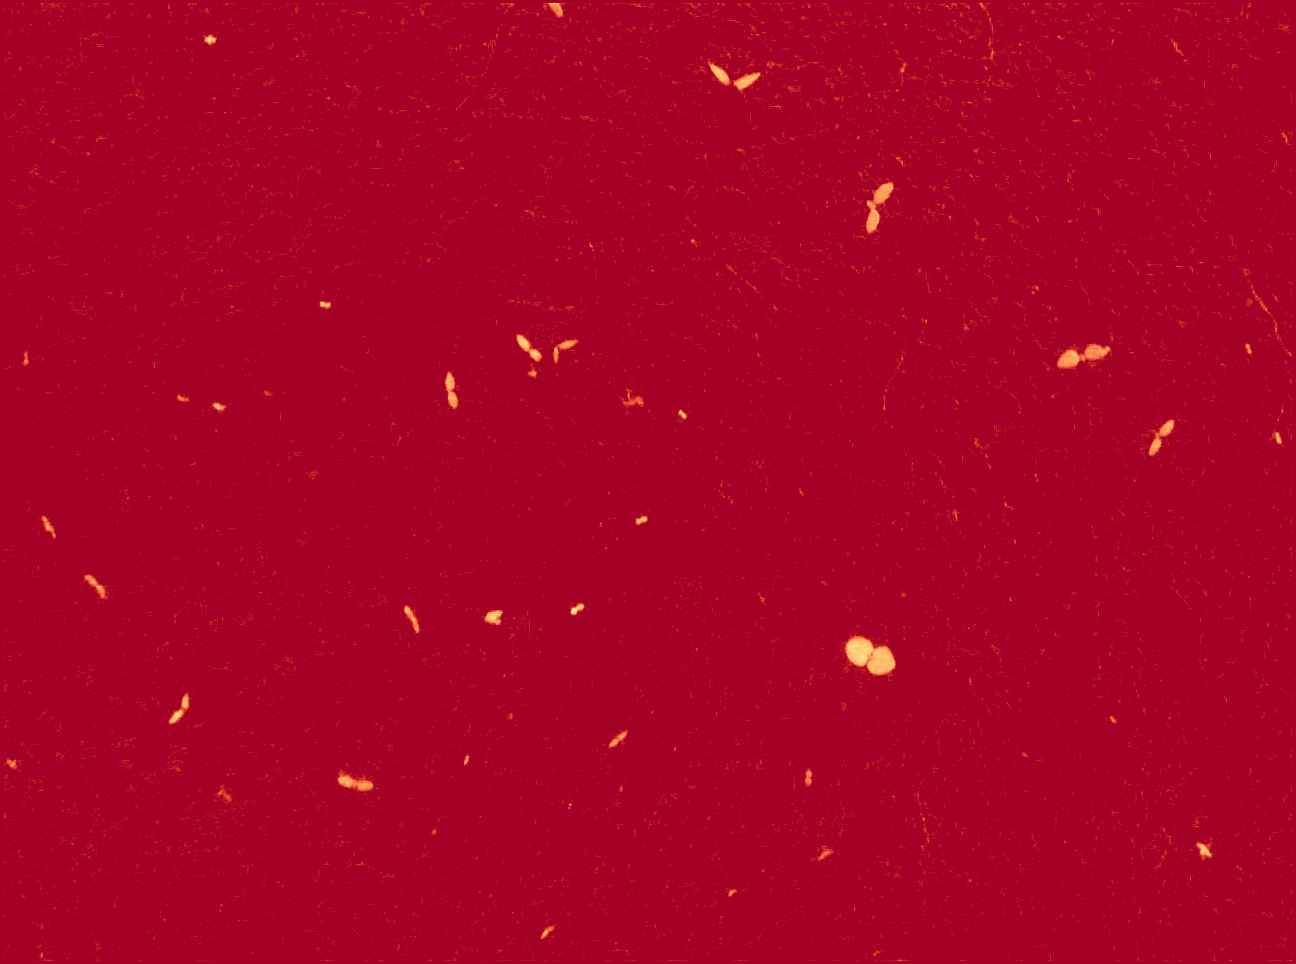

In [9]:
colormap = plt.get_cmap('RdYlGn')
cm1 = colormap(ndvi_img)
cm1 = Image.fromarray((cm1*255).astype(np.uint8))
cm1

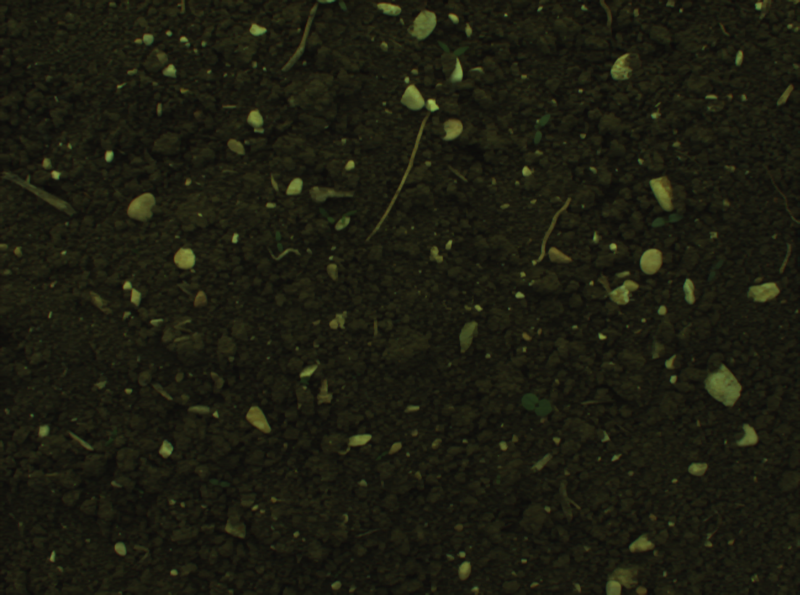

In [10]:
def load_image(image_path: str) -> Tuple[np.array, torch.Tensor]:
    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image_source = Image.open(image_path).convert("RGB")
    image_source.thumbnail((800,800))
    image = np.asarray(image_source)
    image_transformed, _ = transform(image_source, None)
    return image, image_transformed

img_src, img = load_image(rgb_path)
Image.fromarray(img_src)

In [11]:
def load_model(path, config, device='cpu'):
    args = SLConfig.fromfile(config)
    args.device = device
    model = build_model(args)

    checkpoint = torch.load(path, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(path, log))
    _ = model.eval()
    return model

gdmodel = load_model("Models/groundingdino_swinb_cogcoor.pth", "Models/GroundingDINO_SwinB.cfg.py", device)

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model loaded from Models/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


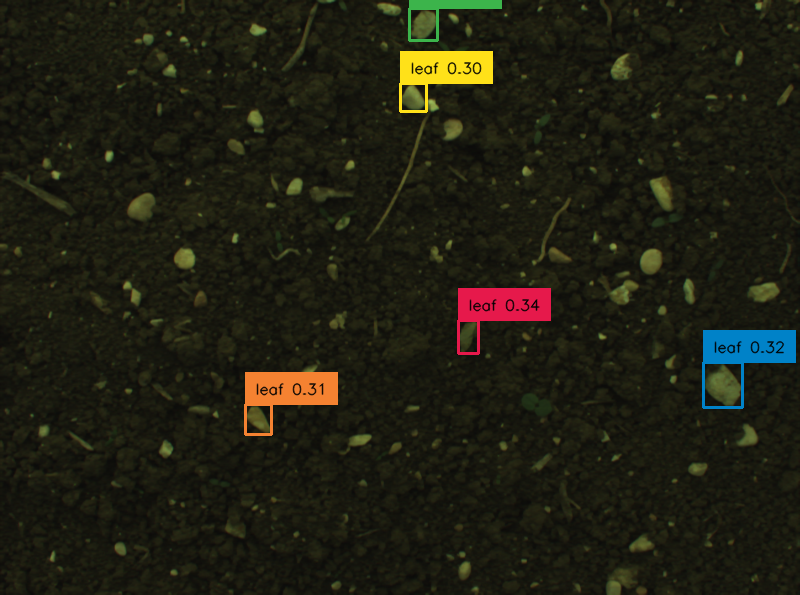

In [14]:
boxes, logits, phrases = predict(model = gdmodel, image = img, caption = "leaf", box_threshold = 0.3, text_threshold = 0.25)
frame = annotate(image_source = img_src, boxes = boxes, logits = logits, phrases = phrases)
frame = frame[...,::-1]
Image.fromarray(frame)

In [16]:
sam = SamPredictor(build_sam(checkpoint="Models/sam_vit_h_4b8939.pth").to(device))

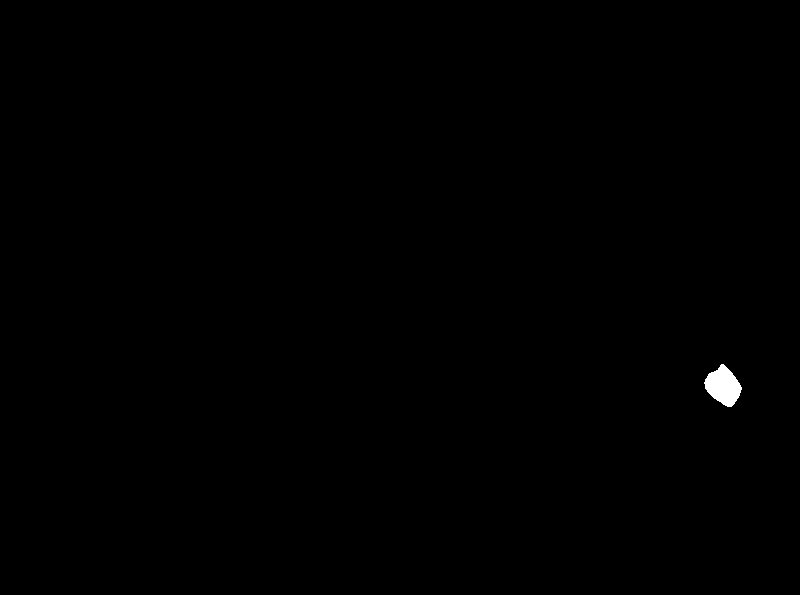

In [17]:
def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return masks.cpu()

segmented_frame_masks = segment(img_src, sam, boxes=boxes)
Image.fromarray(segmented_frame_masks[3][0].numpy())

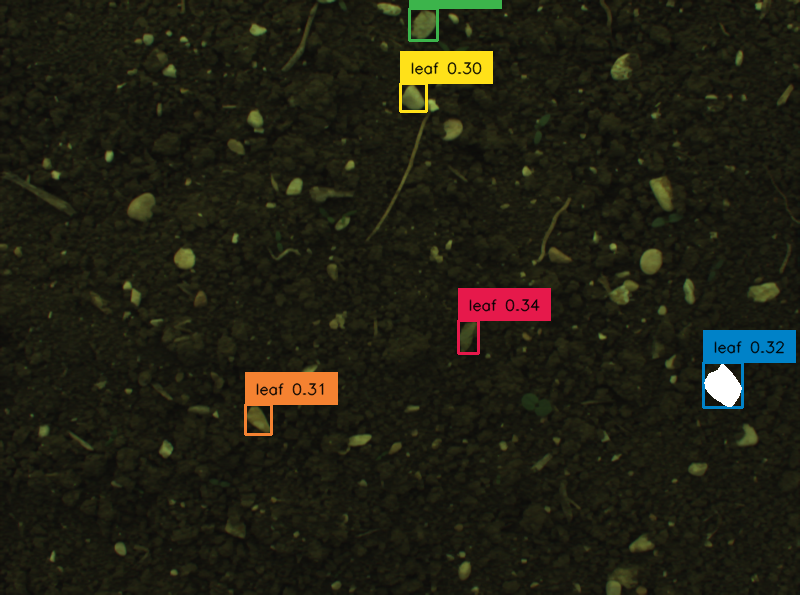

In [18]:
def draw_mask(mask, img):
  color = np.array([1, 1, 1, 1])
  h, w = mask.shape[-2:]
  mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
  annotated_frame_pil = Image.fromarray(img).convert("RGBA")
  mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")
  return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

annotated_frame_with_mask = draw_mask(segmented_frame_masks[3][0], frame)
Image.fromarray(annotated_frame_with_mask)


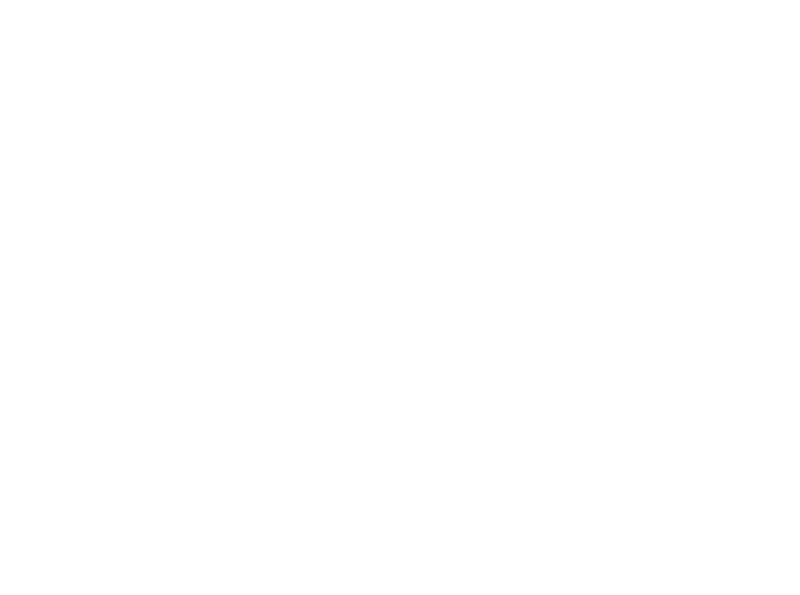

In [19]:
def draw_mask(mask, image):
    color = np.array([1, 1, 1, 1])
    dark_image = np.array(image)
    dark_image_pil = Image.fromarray(dark_image.astype(np.uint8)).convert("RGBA")
    result_image = Image.new("RGBA", dark_image_pil.size, (0, 0, 0, 0))

    for i, m in enumerate(mask.numpy()):
        h, w = m.shape[-2:]
        mask_image = m.reshape(h, w, 1) * color.reshape(1, 1, -1)
        mask_image_pil = Image.fromarray((mask_image * 255).astype(np.uint8)).convert("RGBA")
        result_image.paste(mask_image_pil, (0, 0), mask_image_pil)

    return np.array(result_image)

annotated_frame_with_mask = draw_mask(segmented_frame_masks, frame)
Image.fromarray(annotated_frame_with_mask)

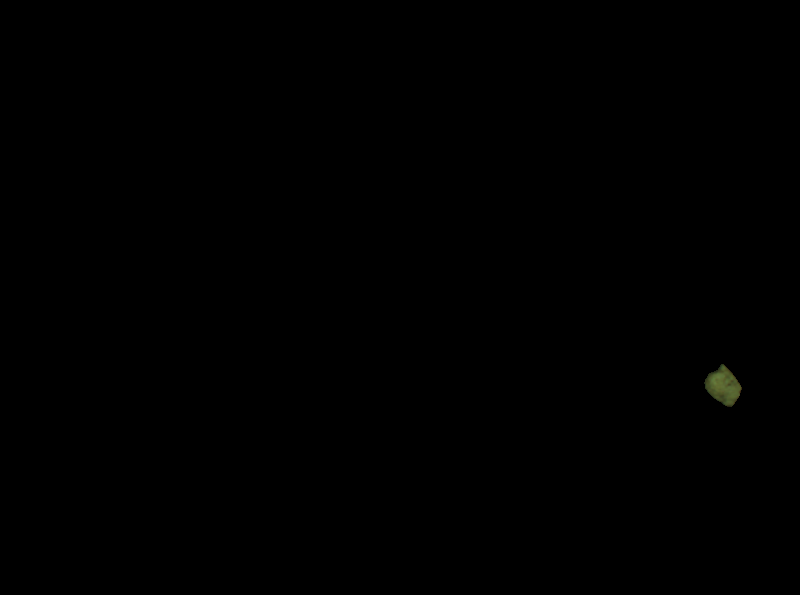

In [20]:
m = segmented_frame_masks[3][0]
rgb_segment = np.zeros_like(img_src)
rgb_segment[np.where(m != 0)] = img_src[np.where(m != 0)]
r = rgb_segment[:,:,0]
g = rgb_segment[:,:,1]
b = rgb_segment[:,:,2]
Image.fromarray(rgb_segment)

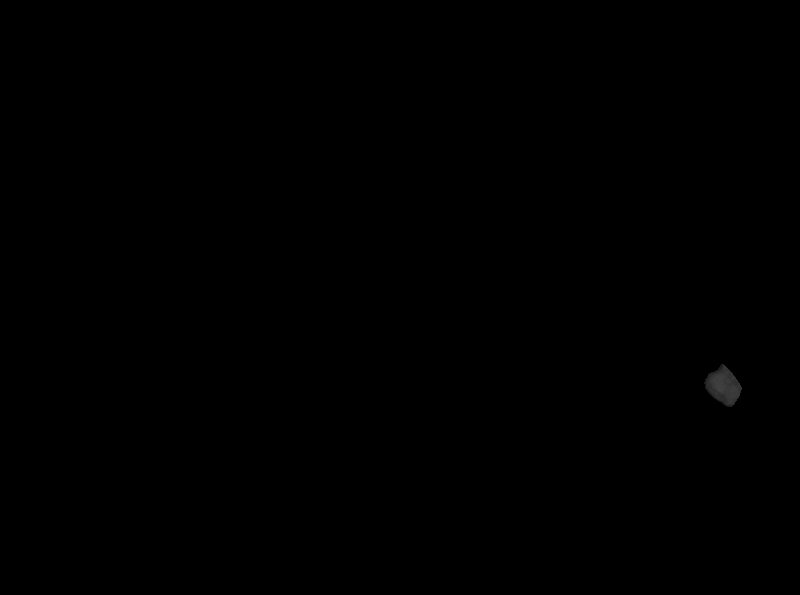

In [24]:
nir.thumbnail((800,800))
nir_src = np.array(nir)
nir_segment = np.zeros_like(nir_src)
nir_segment[np.where(m != 0)] = nir_src[np.where(m != 0)]
Image.fromarray(nir_segment)

In [22]:
def segmented_ndvi(m, b1, b2, b3 = 0):
  h, w = m.shape
  ndvi = []
  n, _, _ = calculate_ndvi(b1, b2, b3)
  for i in range(h):
    for j in range(w):
      if m[i][j]:
        ndvi.append(n[i][j])
  print(len(ndvi))
  ndvi_mean = np.mean(ndvi)
  ndif = np.zeros_like(m)
  ndif[np.where(m!= 0)] = n[np.where(m!= 0)]
  return ndif, (ndif * 255).astype(np.uint8), ndvi_mean

/var/tmp/ipykernel_4236/2262774167.py:7: RuntimeWarning: invalid value encountered in divide
  n_diff = (b2 - b1) / (b1 + b2 - b3)
/var/tmp/ipykernel_4236/2262774167.py:14: RuntimeWarning: invalid value encountered in cast
  return n_diff, (n_diff*255).astype(np.uint8), ndvi_mean


1020
-0.20224370919070658


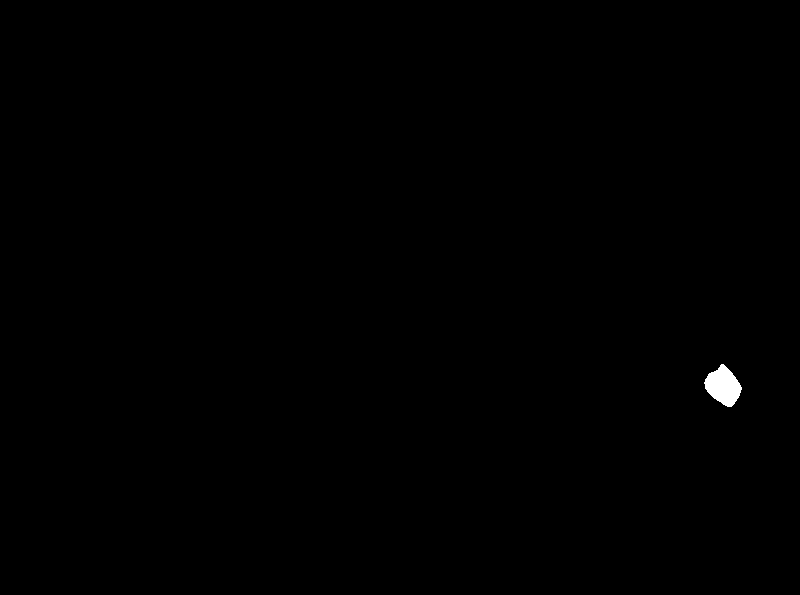

In [25]:
_, ndvi_segment, mean_ndvi = segmented_ndvi(m, r, nir_segment)
print(mean_ndvi)
Image.fromarray(ndvi_segment)

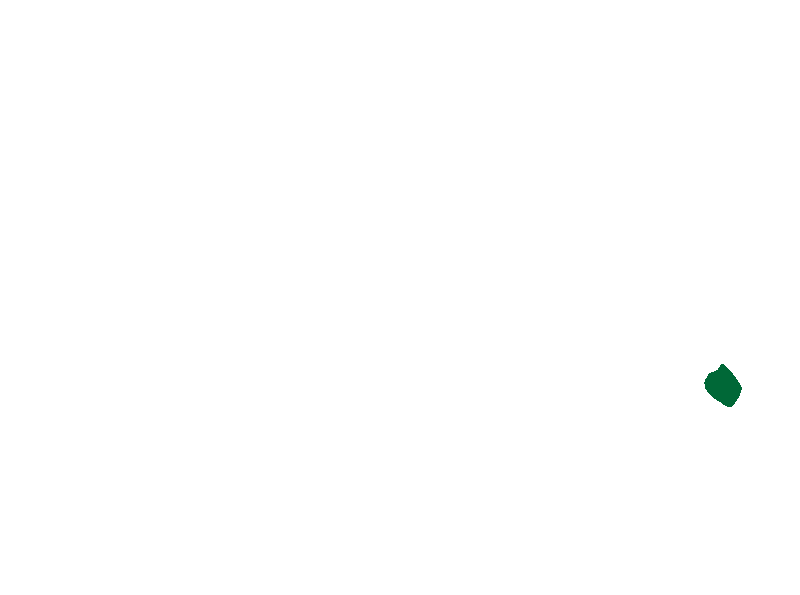

In [26]:
cms1 = colormap(ndvi_segment)
cms1 = (cms1*255).astype(np.uint8)
temp = np.zeros_like(cms1)
temp[np.where(m !=0)] = cms1[np.where(m != 0)]
Image.fromarray(temp)